# MODELOS DE REDES PARA DENGUE PIEDECUESTA

### Cargue de librerias requeridas

In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
from pandas import concat
from pandas import read_csv
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
import os
import datetime
import IPython
import IPython.display
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Flatten, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Input, Reshape, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline
from scipy.stats import randint as sp_randint
np.random.seed(123) # for reproducibility
import warnings
warnings.filterwarnings('ignore')

### Cargar la base de datos

In [2]:
datos = read_csv('Piedecuesta_Lags.csv', encoding='latin-1', sep=";")
datos.columns

Index(['Municipio', 'Año', 'Semana_Epi', 'Casos_Dengue', 'Prom_Dia_Preci',
       'Prom_Dia_Preci_1', 'Prom_Dia_Preci_2', 'Prom_Dia_Preci_3',
       'Prom_Dia_Preci_4', 'Prom_Dia_Preci_5', 'Prom_Dia_Preci_6',
       'Total_Preci_Sem', 'Total_Preci_Sem_1', 'Total_Preci_Sem_2',
       'Total_Preci_Sem_3', 'Total_Preci_Sem_4', 'Total_Preci_Sem_5',
       'Total_Preci_Sem_6'],
      dtype='object')

In [3]:
# Se eliminan las columnas de las variables que No se van a utilizar
datos = datos.drop(['Municipio', 'Año', 'Semana_Epi','Prom_Dia_Preci','Prom_Dia_Preci_6',
                    'Prom_Dia_Preci_1', 'Prom_Dia_Preci_3', 'Prom_Dia_Preci_4', 'Prom_Dia_Preci_5',
                    'Total_Preci_Sem', 'Total_Preci_Sem_6', 'Total_Preci_Sem_1',
                    'Total_Preci_Sem_3', 'Total_Preci_Sem_4', 'Total_Preci_Sem_5'],axis=1)

datos.columns

Index(['Casos_Dengue', 'Prom_Dia_Preci_2', 'Total_Preci_Sem_2'], dtype='object')

In [4]:
#Se verifican datos nulos o faltantes
datos.isnull().sum()

Casos_Dengue         0
Prom_Dia_Preci_2     6
Total_Preci_Sem_2    6
dtype: int64

In [5]:
from sklearn.impute import KNNImputer
knnImputer = KNNImputer (missing_values=np.nan, n_neighbors=2, 
                         weights="uniform", metric="nan_euclidean")
knnImputer.fit(datos[['Prom_Dia_Preci_2']])
datos['Prom_Dia_Preci_2'] = knnImputer.transform(datos[['Prom_Dia_Preci_2']]).ravel()
knnImputer.fit(datos[['Total_Preci_Sem_2']])
datos['Total_Preci_Sem_2'] = knnImputer.transform(datos[['Total_Preci_Sem_2']]).ravel()

In [6]:
#Se verifican datos nulos o faltantes
datos.isnull().sum()

Casos_Dengue         0
Prom_Dia_Preci_2     0
Total_Preci_Sem_2    0
dtype: int64

### División de los datos en set de entrenamiento y prueba

In [7]:
train_size = int(len(datos) * 0.7)
test_size = len(datos) - train_size
train, test = datos.iloc[0:train_size], datos.iloc[train_size:len(datos)]
print(len(train), len(test))

473 203


In [8]:
f_columns = ['Prom_Dia_Preci_2', 'Total_Preci_Sem_2']
f_transformer = MinMaxScaler(feature_range=(0, 1))
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

In [9]:
dengue_transformer = MinMaxScaler(feature_range=(0, 1))
dengue_transformer = dengue_transformer.fit(train[['Casos_Dengue']])
train['Casos_Dengue'] = dengue_transformer.transform(train[['Casos_Dengue']])
test['Casos_Dengue'] = dengue_transformer.transform(test[['Casos_Dengue']])

In [10]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# MODELO LSTM

In [11]:
# Creación de X_train, y_train, X_test y y_test Para el modelo LSTM

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_LSTM, y_train_LSTM = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_LSTM, y_test_LSTM = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_LSTM.shape, y_train_LSTM.shape, X_test_LSTM.shape, y_test_LSTM.shape )

(466, 7, 3) (466,) (196, 7, 3) (196,)


### Construcción, Compilación y entrenamiento del modelo LSTM

In [12]:
Piede_LSTM_model_2 = keras.Sequential()
    
# CAPA DE ENTRADA
Piede_LSTM_model_2.add(keras.layers.InputLayer(input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    
    
#CAPAS INTERMEDIAS

Piede_LSTM_model_2.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Piede_LSTM_model_2.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Piede_LSTM_model_2.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Piede_LSTM_model_2.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Piede_LSTM_model_2.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Piede_LSTM_model_3.h5'
checkpoint_LSTM = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_LSTM = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_LSTM = Piede_LSTM_model_2.fit(X_train_LSTM,y_train_LSTM, validation_data=(X_test_LSTM,y_test_LSTM), 
                                     verbose=2, epochs=100, callbacks=[monitor_LSTM, checkpoint_LSTM])
Piede_LSTM_model_2.load_weights(model_filepath)

Epoch 1/100
15/15 - 10s - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0215 - val_mse: 0.0215 - 10s/epoch - 685ms/step
Epoch 2/100
15/15 - 1s - loss: 0.0280 - mse: 0.0280 - val_loss: 0.0190 - val_mse: 0.0190 - 569ms/epoch - 38ms/step
Epoch 3/100
15/15 - 1s - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0111 - val_mse: 0.0111 - 588ms/epoch - 39ms/step
Epoch 4/100
15/15 - 0s - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0122 - val_mse: 0.0122 - 463ms/epoch - 31ms/step
Epoch 5/100
15/15 - 0s - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0122 - val_mse: 0.0122 - 455ms/epoch - 30ms/step
Epoch 6/100
15/15 - 0s - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0115 - val_mse: 0.0115 - 424ms/epoch - 28ms/step
Epoch 7/100
15/15 - 0s - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0092 - val_mse: 0.0092 - 487ms/epoch - 32ms/step
Epoch 8/100
15/15 - 1s - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0084 - val_mse: 0.0084 - 518ms/epoch - 35ms/step
Epoch 9/100
15/15 - 1s - loss: 0.0185 - mse: 0.0185 - val_loss: 0.0106 - val_mse

# MODELO CNN

In [13]:
# Creación de X_train, y_train, X_test y y_test Para el modelo CNN

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_CNN, y_train_CNN = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_CNN, y_test_CNN = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_CNN.shape, y_train_CNN.shape, X_test_CNN.shape, y_test_CNN.shape )

(466, 7, 3) (466,) (196, 7, 3) (196,)


### Construcción, Compilación y entrenamiento del modelo CNN

In [14]:
Piede_CNN_model_2 = keras.Sequential()
    
# CAPA DE ENTRADA
Piede_CNN_model_2.add(keras.layers.InputLayer(input_shape=(X_train_CNN.shape[1], X_train_CNN.shape[2])))
    
    
#CAPAS INTERMEDIAS

Piede_CNN_model_2.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='tanh', padding='same'))
Piede_CNN_model_2.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Piede_CNN_model_2.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='tanh', padding='same'))
Piede_CNN_model_2.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Piede_CNN_model_2.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='tanh', padding='same'))
Piede_CNN_model_2.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Piede_CNN_model_2.add(Dropout(0.5))
Piede_CNN_model_2.add(Flatten())
    
Piede_CNN_model_2.add(keras.layers.Dense(units=256, activation='tanh'))
Piede_CNN_model_2.add(Dropout(0.5)) 


#CAPA DE SALIDA                 
Piede_CNN_model_2.add(Dense(1))


#COMPILACIÓN DEL MODELO
Piede_CNN_model_2.compile(optimizer='rmsprop', loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Piede_CNN_model_3.h5'
checkpoint_CNN = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_CNN = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_CNN = Piede_CNN_model_2.fit(X_train_CNN,y_train_CNN, validation_data=(X_test_CNN,y_test_CNN), 
                                     verbose=2, epochs=100, callbacks=[monitor_CNN, checkpoint_CNN])
Piede_CNN_model_2.load_weights(model_filepath)

Epoch 1/100
15/15 - 1s - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0061 - val_mse: 0.0061 - 1s/epoch - 82ms/step
Epoch 2/100
15/15 - 0s - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0091 - val_mse: 0.0091 - 94ms/epoch - 6ms/step
Epoch 3/100
15/15 - 0s - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0076 - val_mse: 0.0076 - 94ms/epoch - 6ms/step
Epoch 4/100
15/15 - 0s - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0083 - val_mse: 0.0083 - 100ms/epoch - 7ms/step
Epoch 5/100
15/15 - 0s - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0072 - val_mse: 0.0072 - 100ms/epoch - 7ms/step
Epoch 6/100
15/15 - 0s - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0060 - val_mse: 0.0060 - 141ms/epoch - 9ms/step


# MODELO RNN

In [15]:
# Creación de X_train, y_train, X_test y y_test Para el modelo RNN

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_RNN, y_train_RNN = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_RNN, y_test_RNN = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_RNN.shape, y_train_RNN.shape, X_test_RNN.shape, y_test_RNN.shape )

(466, 7, 3) (466,) (196, 7, 3) (196,)


### Construcción, Compilación y entrenamiento del modelo RNN

In [16]:
Piede_RNN_model_2 = keras.Sequential()
    
# CAPA DE ENTRADA
Piede_RNN_model_2.add(keras.layers.InputLayer(input_shape=(X_train_RNN.shape[1], X_train_RNN.shape[2])))
    
    
#CAPAS INTERMEDIAS

Piede_RNN_model_2.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Piede_RNN_model_2.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Piede_RNN_model_2.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Piede_RNN_model_2.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Piede_RNN_model_2.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Piede_RNN_model_3.h5'
checkpoint_RNN = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_RNN = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_RNN = Piede_RNN_model_2.fit(X_train_RNN,y_train_RNN, validation_data=(X_test_RNN,y_test_RNN), 
                                     verbose=2, epochs=100, callbacks=[monitor_RNN, checkpoint_RNN])
Piede_RNN_model_2.load_weights(model_filepath)

Epoch 1/100
15/15 - 5s - loss: 0.0375 - mse: 0.0375 - val_loss: 0.0115 - val_mse: 0.0115 - 5s/epoch - 353ms/step
Epoch 2/100
15/15 - 0s - loss: 0.0219 - mse: 0.0219 - val_loss: 0.0119 - val_mse: 0.0119 - 188ms/epoch - 13ms/step
Epoch 3/100
15/15 - 0s - loss: 0.0248 - mse: 0.0248 - val_loss: 0.0087 - val_mse: 0.0087 - 236ms/epoch - 16ms/step
Epoch 4/100
15/15 - 0s - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0136 - val_mse: 0.0136 - 188ms/epoch - 13ms/step
Epoch 5/100
15/15 - 0s - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0109 - val_mse: 0.0109 - 176ms/epoch - 12ms/step
Epoch 6/100
15/15 - 0s - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0103 - val_mse: 0.0103 - 188ms/epoch - 13ms/step
Epoch 7/100
15/15 - 0s - loss: 0.0233 - mse: 0.0233 - val_loss: 0.0094 - val_mse: 0.0094 - 188ms/epoch - 13ms/step
Epoch 8/100
15/15 - 0s - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0083 - val_mse: 0.0083 - 236ms/epoch - 16ms/step


# MODELO GRU

In [17]:
# Creación de X_train, y_train, X_test y y_test Para el modelo GRU

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_GRU, y_train_GRU = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_GRU, y_test_GRU = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_GRU.shape, y_train_GRU.shape, X_test_GRU.shape, y_test_GRU.shape )

(466, 7, 3) (466,) (196, 7, 3) (196,)


### Construcción, Compilación y entrenamiento del modelo GRU

In [18]:
Piede_GRU_model_2 = keras.Sequential()
    
# CAPA DE ENTRADA
Piede_GRU_model_2.add(keras.layers.InputLayer(input_shape=(X_train_GRU.shape[1], X_train_GRU.shape[2])))
    
    
#CAPAS INTERMEDIAS

Piede_GRU_model_2.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Piede_GRU_model_2.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Piede_GRU_model_2.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Piede_GRU_model_2.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Piede_GRU_model_2.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Piede_GRU_model_3.h5'
checkpoint_GRU = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_GRU = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_GRU = Piede_GRU_model_2.fit(X_train_GRU,y_train_GRU, validation_data=(X_test_GRU,y_test_GRU), 
                                     verbose=2, epochs=100, callbacks=[monitor_GRU, checkpoint_GRU])
Piede_GRU_model_2.load_weights(model_filepath)

Epoch 1/100
15/15 - 9s - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0163 - val_mse: 0.0163 - 9s/epoch - 600ms/step
Epoch 2/100
15/15 - 1s - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0098 - val_mse: 0.0098 - 502ms/epoch - 33ms/step
Epoch 3/100
15/15 - 0s - loss: 0.0206 - mse: 0.0206 - val_loss: 0.0097 - val_mse: 0.0097 - 471ms/epoch - 31ms/step
Epoch 4/100
15/15 - 0s - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0086 - val_mse: 0.0086 - 482ms/epoch - 32ms/step
Epoch 5/100
15/15 - 0s - loss: 0.0198 - mse: 0.0198 - val_loss: 0.0101 - val_mse: 0.0101 - 424ms/epoch - 28ms/step
Epoch 6/100
15/15 - 0s - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0120 - val_mse: 0.0120 - 454ms/epoch - 30ms/step
Epoch 7/100
15/15 - 0s - loss: 0.0222 - mse: 0.0222 - val_loss: 0.0129 - val_mse: 0.0129 - 456ms/epoch - 30ms/step
Epoch 8/100
15/15 - 0s - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0111 - val_mse: 0.0111 - 440ms/epoch - 29ms/step
Epoch 9/100
15/15 - 0s - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0091 - val_mse: 

### Graficas de función de pérdida & RMSE

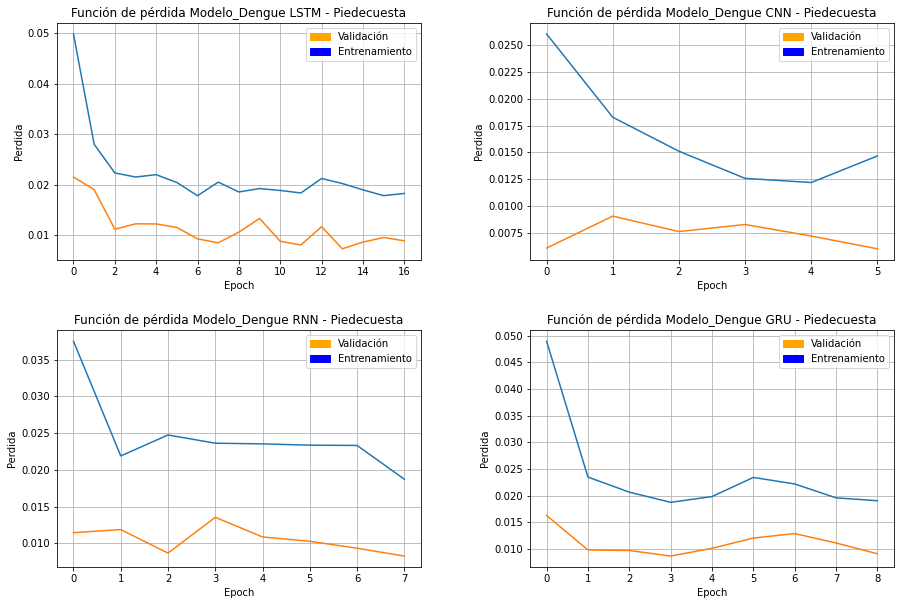

In [19]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue LSTM - Piedecuesta')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])

plt.subplot(2, 2, 2)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue CNN - Piedecuesta')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])

plt.subplot(2, 2, 3)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue RNN - Piedecuesta')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])

plt.subplot(2, 2, 4)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue GRU - Piedecuesta')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])

plt.show()

# Gráficas de dispersión

7/7 [==============================] - 2s 8ms/step


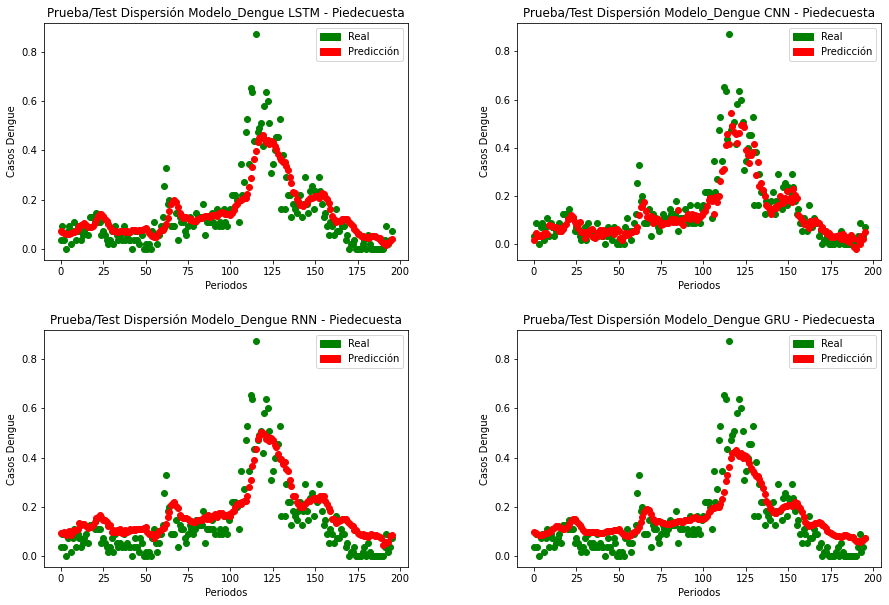

In [20]:
results_LSTM =Piede_LSTM_model_2.predict(X_test_LSTM)
results_CNN =Piede_CNN_model_2.predict(X_test_CNN)
results_RNN =Piede_RNN_model_2.predict(X_test_RNN)
results_GRU =Piede_GRU_model_2.predict(X_test_GRU)

plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue LSTM - Piedecuesta')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_LSTM)),y_test_LSTM,c='g')
plt.scatter(range(len(results_LSTM)),results_LSTM,c='r')

plt.subplot(2, 2, 2)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue CNN - Piedecuesta')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_CNN)),y_test_CNN,c='g')
plt.scatter(range(len(results_CNN)),results_CNN,c='r')

plt.subplot(2, 2, 3)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue RNN - Piedecuesta')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_RNN)),y_test_RNN,c='g')
plt.scatter(range(len(results_RNN)),results_RNN,c='r')

plt.subplot(2, 2, 4)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue GRU - Piedecuesta')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_GRU)),y_test_GRU,c='g')
plt.scatter(range(len(results_GRU)),results_GRU,c='r')

plt.show()

In [21]:
y_pred_LSTM = Piede_LSTM_model_2.predict(X_test_LSTM)
y_pred_CNN = Piede_CNN_model_2.predict(X_test_CNN)
y_pred_RNN = Piede_RNN_model_2.predict(X_test_RNN)
y_pred_GRU = Piede_GRU_model_2.predict(X_test_GRU)

y_train_inv_LSTM = dengue_transformer.inverse_transform(y_train_LSTM.reshape(1, -1))
y_train_inv_CNN = dengue_transformer.inverse_transform(y_train_CNN.reshape(1, -1))
y_train_inv_RNN = dengue_transformer.inverse_transform(y_train_RNN.reshape(1, -1))
y_train_inv_GRU = dengue_transformer.inverse_transform(y_train_GRU.reshape(1, -1))

y_test_inv_LSTM = dengue_transformer.inverse_transform(y_test_LSTM.reshape(1, -1))
y_test_inv_CNN = dengue_transformer.inverse_transform(y_test_CNN.reshape(1, -1))
y_test_inv_RNN = dengue_transformer.inverse_transform(y_test_RNN.reshape(1, -1))
y_test_inv_GRU = dengue_transformer.inverse_transform(y_test_GRU.reshape(1, -1))

y_pred_inv_LSTM = dengue_transformer.inverse_transform(y_pred_LSTM)
y_pred_inv_CNN = dengue_transformer.inverse_transform(y_pred_CNN)
y_pred_inv_RNN = dengue_transformer.inverse_transform(y_pred_RNN)
y_pred_inv_GRU = dengue_transformer.inverse_transform(y_pred_GRU)

7/7 [==============================] - 0s 8ms/step


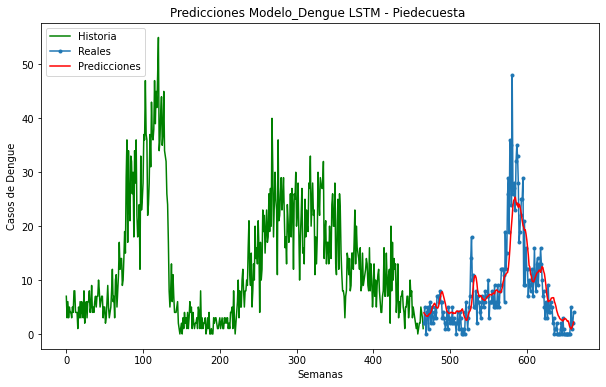

In [22]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_LSTM)), y_train_inv_LSTM.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_LSTM), len(y_train_LSTM) + len(y_test_LSTM)), y_test_inv_LSTM.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_LSTM), len(y_train_LSTM) + len(y_test_LSTM)), y_pred_inv_LSTM.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue LSTM - Piedecuesta ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

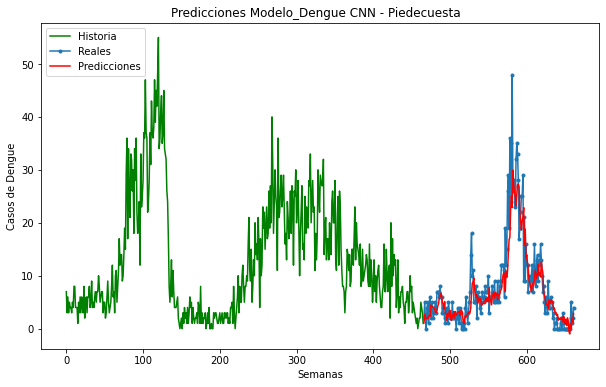

In [23]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_CNN)), y_train_inv_CNN.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_CNN), len(y_train_CNN) + len(y_test_CNN)), y_test_inv_CNN.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_CNN), len(y_train_CNN) + len(y_test_CNN)), y_pred_inv_CNN.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue CNN - Piedecuesta  ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

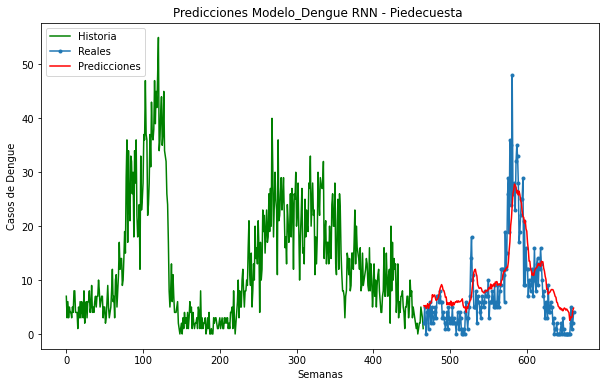

In [24]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_RNN)), y_train_inv_RNN.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_RNN), len(y_train_RNN) + len(y_test_RNN)), y_test_inv_RNN.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_RNN), len(y_train_RNN) + len(y_test_RNN)), y_pred_inv_RNN.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue RNN - Piedecuesta ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

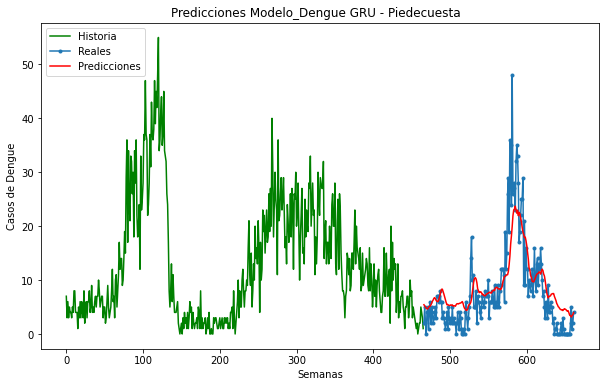

In [25]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_GRU)), y_train_inv_GRU.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_GRU), len(y_train_GRU) + len(y_test_GRU)), y_test_inv_GRU.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_GRU), len(y_train_GRU) + len(y_test_GRU)), y_pred_inv_GRU.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue GRU - Piedecuesta  ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

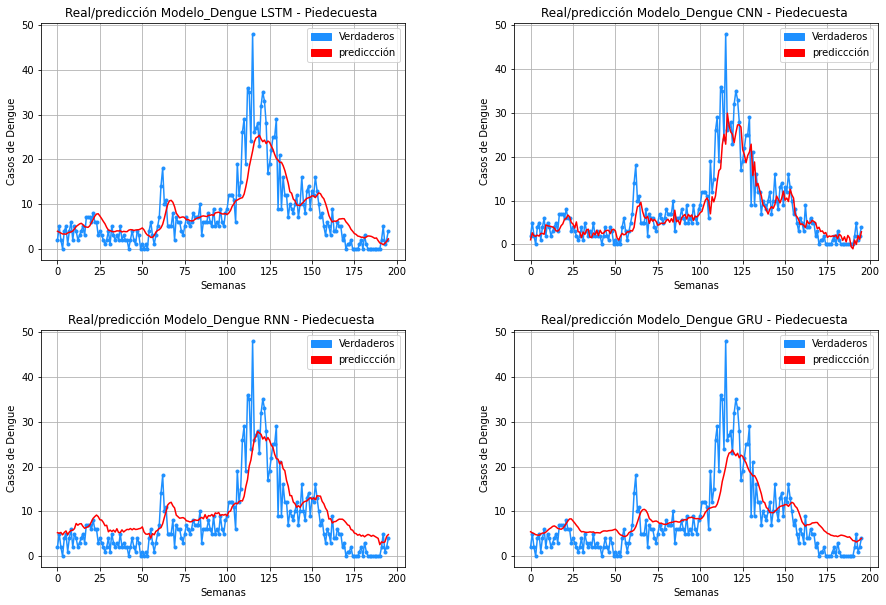

In [26]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
plt.title('Real/predicción Modelo_Dengue LSTM - Piedecuesta ' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_LSTM.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_LSTM.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('Real/predicción Modelo_Dengue CNN - Piedecuesta ' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_CNN.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_CNN.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.title('Real/predicción Modelo_Dengue RNN - Piedecuesta ' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_RNN.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_RNN.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.title('Real/predicción Modelo_Dengue GRU - Piedecuesta ' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_GRU.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_GRU.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.show()

In [27]:
score_LSTM = np.sqrt(metrics.mean_squared_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
score_CNN = np.sqrt(metrics.mean_squared_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
score_RNN = np.sqrt(metrics.mean_squared_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
score_GRU = np.sqrt(metrics.mean_squared_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

print("RMSE Modelo_2 LSTM Dengue Piedecuesta : {}".format(score_LSTM))
print("RMSE Modelo_2  CNN Dengue  Piedecuesta   : {}".format(score_CNN))
print("RMSE Modelo_2  RNN Dengue  Piedecuesta : {}".format(score_RNN))
print("RMSE Modelo_2  GRU Dengue  Piedecuesta   : {}".format(score_GRU))

RMSE Modelo_2 LSTM Dengue Piedecuesta : 4.678322808405843
RMSE Modelo_2  CNN Dengue  Piedecuesta   : 4.266904905129651
RMSE Modelo_2  RNN Dengue  Piedecuesta : 5.008435857380268
RMSE Modelo_2  GRU Dengue  Piedecuesta   : 5.112441873653398


In [28]:
print("MSE Modelo_2  LSTM Dengue Piedecuesta   = ", mean_squared_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("MSE Modelo_2  CNN Dengue Piedecuesta    = ", mean_squared_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("MSE Modelo_2  RNN Dengue Piedecuesta    = ", mean_squared_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("MSE Modelo_2  GRU Dengue Piedecuesta    = ", mean_squared_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

MSE Modelo_2  LSTM Dengue Piedecuesta   =  21.886704299650336
MSE Modelo_2  CNN Dengue Piedecuesta    =  18.206477469419475
MSE Modelo_2  RNN Dengue Piedecuesta    =  25.084429737492414
MSE Modelo_2  GRU Dengue Piedecuesta    =  26.13706191148467


In [29]:
print("MAE Modelo_2  LSTM Dengue Piedecuesta  = ", mean_absolute_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("MAE Modelo_2  CNN Dengue Piedecuesta   = ", mean_absolute_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("MAE Modelo_2  RNN Dengue Piedecuesta   = ", mean_absolute_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("MAE Modelo_2  GRU Dengue Piedecuesta  = ", mean_absolute_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

MAE Modelo_2  LSTM Dengue Piedecuesta  =  3.1981327618871416
MAE Modelo_2  CNN Dengue Piedecuesta   =  2.6620750001166016
MAE Modelo_2  RNN Dengue Piedecuesta   =  3.806502799598538
MAE Modelo_2  GRU Dengue Piedecuesta  =  3.6956426756722585


In [30]:
print("r2_score Modelo_2  LSTM Dengue Piedecuesta   = ", r2_score(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("r2_score Modelo_2  CNN Dengue Piedecuesta  = ", r2_score(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("r2_score Modelo_2  RNN Dengue Piedecuesta   = ", r2_score(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("r2_score Modelo_2  GRU Dengue Piedecuesta  = ", r2_score(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

r2_score Modelo_2  LSTM Dengue Piedecuesta   =  0.6854597917796156
r2_score Modelo_2  CNN Dengue Piedecuesta  =  0.7383494044700722
r2_score Modelo_2  RNN Dengue Piedecuesta   =  0.6395043472649959
r2_score Modelo_2  GRU Dengue Piedecuesta  =  0.6243766634139244


In [31]:
print("explained_variance_score Modelo_2  LSTM Dengue Piedecuesta   = ", explained_variance_score(y_test_inv_LSTM.flatten(), 
                                                                                           y_pred_inv_LSTM.flatten()))
print("explained_variance_score Modelo_2  CNN Dengue Piedecuesta   = ", explained_variance_score(y_test_inv_CNN.flatten(), 
                                                                                           y_pred_inv_CNN.flatten()))
print("explained_variance_score Modelo_2  RNN Dengue Piedecuesta   = ", explained_variance_score(y_test_inv_RNN.flatten(), 
                                                                                           y_pred_inv_RNN.flatten()))
print("explained_variance_score Modelo_2  GRU Dengue Piedecuesta   = ", explained_variance_score(y_test_inv_GRU.flatten(), 
                                                                                           y_test_inv_GRU.flatten()))

explained_variance_score Modelo_2  LSTM Dengue Piedecuesta   =  0.6874274801568532
explained_variance_score Modelo_2  CNN Dengue Piedecuesta   =  0.747972145630728
explained_variance_score Modelo_2  RNN Dengue Piedecuesta   =  0.6932204894368876
explained_variance_score Modelo_2  GRU Dengue Piedecuesta   =  1.0


### VISUALIZACIÓN DE LOS VALORES TESTEADOS VS LAS PREDICCIONES

In [32]:
#MODELO LSTM
resultados_LSTM = pd.DataFrame({ 'Actuales':y_test_inv_LSTM.flatten(), 'Predicciones': y_pred_inv_LSTM.flatten()})
resultados_LSTM['diferencia'] = resultados_LSTM['Predicciones'] - resultados_LSTM['Actuales']
print(resultados_LSTM.head(5))
print(resultados_LSTM.tail(5))

   Actuales  Predicciones  diferencia
0       2.0      3.922660    1.922660
1       5.0      3.713747   -1.286253
2       2.0      3.531900    1.531900
3       0.0      3.308895    3.308895
4       4.0      3.310997   -0.689003
     Actuales  Predicciones  diferencia
191       2.0      1.193395   -0.806605
192       5.0      0.907347   -4.092653
193       1.0      1.236194    0.236194
194       2.0      1.645919   -0.354081
195       4.0      2.225690   -1.774310


In [33]:
#MODELO CNN
resultados_CNN = pd.DataFrame({ 'Actuales':y_test_inv_CNN.flatten(), 'Predicciones': y_pred_inv_CNN.flatten()})
resultados_CNN['diferencia'] = resultados_CNN['Predicciones'] - resultados_CNN['Actuales']
print(resultados_CNN.head(5))
print(resultados_CNN.tail(5))

   Actuales  Predicciones  diferencia
0       2.0      1.056594   -0.943406
1       5.0      2.659014   -2.340986
2       2.0      1.970214   -0.029786
3       0.0      1.853393    1.853393
4       4.0      2.110856   -1.889144
     Actuales  Predicciones  diferencia
191       2.0      0.997932   -1.002068
192       5.0     -0.001663   -5.001663
193       1.0      1.999235    0.999235
194       2.0      1.154297   -0.845703
195       4.0      2.889776   -1.110224


In [34]:
#MODELO RNN
resultados_RNN = pd.DataFrame({ 'Actuales':y_test_inv_RNN.flatten(), 'Predicciones': y_pred_inv_RNN.flatten()})
resultados_RNN['diferencia'] = resultados_RNN['Predicciones'] - resultados_RNN['Actuales']
print(resultados_RNN.head(5))
print(resultados_RNN.tail(5))

   Actuales  Predicciones  diferencia
0       2.0      5.229467    3.229467
1       5.0      5.090065    0.090065
2       2.0      5.277504    3.277504
3       0.0      4.742081    4.742081
4       4.0      5.268052    1.268052
     Actuales  Predicciones  diferencia
191       2.0      3.165125    1.165125
192       5.0      3.022361   -1.977639
193       1.0      3.159108    2.159108
194       2.0      4.385678    2.385678
195       4.0      4.792914    0.792914


In [35]:
#MODELO GRU
resultados_GRU = pd.DataFrame({ 'Actuales':y_test_inv_GRU.flatten(), 'Predicciones': y_pred_inv_GRU.flatten()})
resultados_GRU['diferencia'] = resultados_GRU['Predicciones'] - resultados_GRU['Actuales']
print(resultados_GRU.head(5))
print(resultados_GRU.tail(5))

   Actuales  Predicciones  diferencia
0       2.0      5.427121    3.427121
1       5.0      5.193545    0.193545
2       2.0      5.028233    3.028233
3       0.0      4.784005    4.784005
4       4.0      4.696081    0.696081
     Actuales  Predicciones  diferencia
191       2.0      3.391909    1.391909
192       5.0      3.136575   -1.863425
193       1.0      3.374901    2.374901
194       2.0      3.607399    1.607399
195       4.0      3.965227   -0.034773
